# *Model:* ARMA
# *Stock Data:* NSEI
# *Name: *Abbas Amjherawala**

In [1]:
!pip install pmdarima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta, timezone
from time import time
from pmdarima.arima import auto_arima
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.3 MB/s eta 0:00:00a 0:00:01


In [2]:
_df = pd.read_csv('/kaggle/input/nsei-prev-data/in_nsei_daily.csv', index_col='minute', parse_dates=True)
_df = _df.interpolate()
train_data = _df[:'2020-12-31']
test_data = _df['2021-01-01':]
print(train_data)
print(test_data)

                          ticker    instrument_token      open      high  \
minute                                                                     
2017-01-02 09:15:00+05:30   NSEI  uf-n-1647516806122   8211.70   8211.70   
2017-01-03 09:15:00+05:30   NSEI  uf-n-1647516806122   8195.25   8219.00   
2017-01-04 09:15:00+05:30   NSEI  uf-n-1647516806122   8201.60   8218.45   
2017-01-05 09:15:00+05:30   NSEI  uf-n-1647516806122   8227.75   8282.55   
2017-01-06 09:15:00+05:30   NSEI  uf-n-1647516806122   8283.50   8306.50   
...                          ...                 ...       ...       ...   
2020-12-24 09:15:00+05:30   NSEI  uf-n-1647516806122  13643.95  13771.75   
2020-12-28 09:15:00+05:30   NSEI  uf-n-1647516806122  13824.40  13885.30   
2020-12-29 09:15:00+05:30   NSEI  uf-n-1647516806122  13915.50  13967.60   
2020-12-30 09:15:00+05:30   NSEI  uf-n-1647516806122  13982.90  13997.00   
2020-12-31 09:15:00+05:30   NSEI  uf-n-1647516806122  13978.25  14024.85   

           

In [3]:
model = auto_arima(train_data['close'], seasonal=True, m=5, 
                   trace=True, error_action='ignore', suppress_warnings=True)
fitted=model.fit(train_data['close'])
print(fitted.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=12188.057, Time=6.42 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=12234.304, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=12215.951, Time=1.01 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=12219.814, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=12234.682, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=12211.889, Time=5.25 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=12207.269, Time=4.77 sec
 ARIMA(2,1,2)(2,0,1)[5] intercept   : AIC=12205.394, Time=8.28 sec
 ARIMA(2,1,2)(1,0,2)[5] intercept   : AIC=12205.614, Time=8.12 sec
 ARIMA(2,1,2)(0,0,0)[5] intercept   : AIC=12225.824, Time=0.64 sec
 ARIMA(2,1,2)(0,0,2)[5] intercept   : AIC=12206.180, Time=5.39 sec
 ARIMA(2,1,2)(2,0,0)[5] intercept   : AIC=12204.183, Time=5.58 sec
 ARIMA(2,1,2)(2,0,2)[5] intercept   : AIC=12207.170, Time=9.51 sec
 ARIMA(1,1,2)(1,0,1)[5] intercept   : AIC=12201.695, Time=4.90 sec
 ARIMA(2,1,1)(1,0,1

In [4]:
forecast = model.predict(n_periods=20)
print(forecast)

987     13990.853516
988     14016.913298
989     13988.573698
990     14034.414442
991     14036.078052
992     14059.681834
993     14078.258762
994     14059.892355
995     14096.245484
996     14098.503678
997     14120.307453
998     14133.977875
999     14122.850025
1000    14151.764621
1001    14154.932394
1002    14174.543389
1003    14185.112842
1004    14179.167944
1005    14202.356523
1006    14206.456829
dtype: float64


In [5]:
import pytz
data_=[]
index_ = test_data.index.tolist()
index_.insert(0, pd.Timestamp('2020-12-31 09:15:00+05:30', tz=pytz.FixedOffset(330)))

try:
    for i in range(1,len(index_)):

        model = ARIMA(train_data['close'], order=(3, 1, 2), seasonal_order=(1, 0, 1, 5))
        fitted = model.fit()
        next_day_price = fitted.forecast()
        predicted_price = next_day_price.values[0]
        
        train_data.loc[index_[i]] = test_data.loc[index_[i]]            
        if predicted_price<train_data[index_[i-1].strftime('%Y-%m-%d')].close[0]:
            direction='SELL'
            data_.append({'Date': index_[i-1].strftime('%Y-%m-%d'),'Day': index_[i-1].strftime('%A'), 'Current Close Price': train_data[index_[i-1].strftime('%Y-%m-%d')].close[0],'Next Day Price': train_data[index_[i].strftime('%Y-%m-%d')].close[0],'Predicted Direction' : direction,'Predicted Value': predicted_price, 'Pnl':train_data[index_[i-1].strftime('%Y-%m-%d')].close[0]-train_data[index_[i].strftime('%Y-%m-%d')].close[0]})
        else:
            direction='BUY'
            data_.append({'Date': index_[i-1].strftime('%Y-%m-%d'),'Day': index_[i-1].strftime('%A'), 'Current Close Price': train_data[index_[i-1].strftime('%Y-%m-%d')].close[0],'Next Day Price': train_data[index_[i].strftime('%Y-%m-%d')].close[0],'Predicted Direction' : direction,'Predicted Value': predicted_price, 'Pnl':train_data[index_[i].strftime('%Y-%m-%d')].close[0]-train_data[index_[i-1].strftime('%Y-%m-%d')].close[0]})

    
except KeyboardInterrupt or ValueError:
    print("Output is Stored in csv file: NSEI_STOCK.CSV!")

In [6]:
import csv
import os

headers = ['Date', 'Day', 'Current Close Price', 'Next Day Price','Predicted Direction', 'Predicted Value','Pnl']

if os.path.exists('/kaggle/working/nsei_stock.csv'):
    with open('nsei_stock.csv', mode='a', newline='') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=headers)
        for row in data_:
            writer.writerow(row)
else:
    with open('nsei_stock.csv', mode='w', newline='') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=headers)
        writer.writeheader()
        for row in data_:
            writer.writerow(row)

data_

[{'Date': '2020-12-31',
  'Day': 'Thursday',
  'Current Close Price': 13967.2,
  'Next Day Price': 14015.1,
  'Predicted Direction': 'BUY',
  'Predicted Value': 13990.643625273578,
  'Pnl': 47.899999999999636},
 {'Date': '2021-01-01',
  'Day': 'Friday',
  'Current Close Price': 14015.1,
  'Next Day Price': 14144.5,
  'Predicted Direction': 'BUY',
  'Predicted Value': 14034.898627365357,
  'Pnl': 129.39999999999964},
 {'Date': '2021-01-04',
  'Day': 'Monday',
  'Current Close Price': 14144.5,
  'Next Day Price': 14196.35,
  'Predicted Direction': 'SELL',
  'Predicted Value': 14118.23569860412,
  'Pnl': -51.850000000000364},
 {'Date': '2021-01-05',
  'Day': 'Tuesday',
  'Current Close Price': 14196.35,
  'Next Day Price': 14132.8,
  'Predicted Direction': 'BUY',
  'Predicted Value': 14228.464802907683,
  'Pnl': -63.55000000000109},
 {'Date': '2021-01-06',
  'Day': 'Wednesday',
  'Current Close Price': 14132.8,
  'Next Day Price': 14148.5,
  'Predicted Direction': 'BUY',
  'Predicted Valu

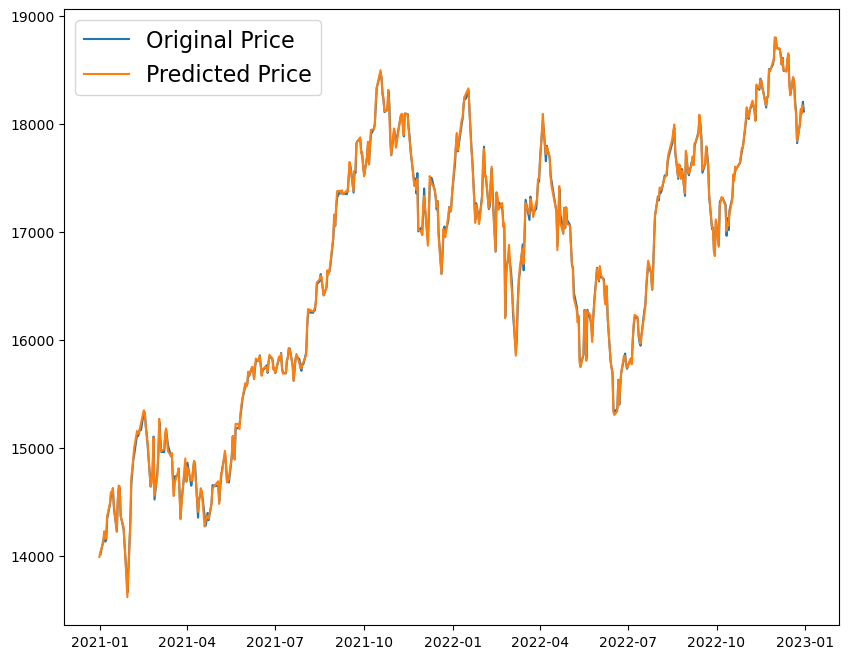

In [16]:
_df = pd.read_csv('/kaggle/working/nsei_stock.csv', index_col='Date', parse_dates=True)
plt.figure(figsize=(10,8))

plt.plot(test_data.close)
plt.plot(_df['Predicted Value'])
plt.legend(('Original Price', 'Predicted Price'), fontsize=16)